# Kernels for Gaussian Process Regression

This demo is interactive. Download and run locally!

<a target="_blank" href="https://colab.research.google.com/github/gpleiss/gp_bo_demos/blob/main/kernel_demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import math
import torch
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from IPython.display import display

# Maybe install requirements
try:
    import gpytorch
except ImportError:
    %pip install gpytorch
    import gpytorch

try:
    import ipympl  # For interactive widgets
except ImportError:
    %pip install ipympl
    import ipympl

# Allow for interactive widgets
try:
    from google.colab import output
    output.enable_custom_widget_manager()
    %matplotlib widget
except ImportError:  # If we're not using google colab
    %matplotlib notebook

In [34]:
class SimpleGP(gpytorch.models.ExactGP):
    def __init__(
        self, train_x, train_y,
        mean="Linear", a=0., b=0.,
        kernel="Matern", nu=2.5, lengthscale=1., var=1.,
        outputscale=1., noise=0.01,
    ):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        super().__init__(train_x, train_y, likelihood)
        
        # Define mean
        if mean == "Linear":
            self.mean_function = gpytorch.means.LinearMean(input_size=1)
            self.mean_function.weights.data.fill_(a)
            self.mean_function.bias.data.fill_(b)
        elif mean == "Zero":
            self.mean_function = gpytorch.means.ZeroMean()
        else:
            raise ValueError(mean)
        
        
        # Define kernel
        if "Matern" in kernel:
            if nu > 2.5:
                matern_kernel = gpytorch.kernels.RBFKernel()  # >2.5 ≈ \infty
            else:
                matern_kernel = gpytorch.kernels.MaternKernel(nu=nu)
            matern_kernel.initialize(lengthscale=lengthscale)
            
        if "Linear" in kernel:
            linear_kernel = gpytorch.kernels.LinearKernel()
            linear_kernel.initialize(variance=var)

        if kernel == "Matern":
            base_kernel = matern_kernel
        elif kernel == "Cosine":
            base_kernel = gpytorch.kernels.CosineKernel()
            base_kernel.initialize(period_length=lengthscale)
        elif kernel == "Linear":
            base_kernel = linear_kernel
        elif kernel == "Linear + Matern":
            base_kernel = linear_kernel + matern_kernel
        elif kernel == "Linear * Matern":
            base_kernel = linear_kernel * matern_kernel
        elif kernel == "Spectral Mixture":
            base_kernel = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=3)
        else:
            raise ValueError(kernel)
        self.kernel_function = gpytorch.kernels.ScaleKernel(base_kernel)

        # Likelihood initialization
        self.kernel_function.initialize(outputscale=outputscale)
        self.likelihood.initialize(noise=noise)
        
    def forward(self, x):
        mean = self.mean_function(x)
        covariance = self.kernel_function(x)
        return gpytorch.distributions.MultivariateNormal(mean, covariance)

Button(description='Reset', style=ButtonStyle())

<IPython.core.display.Javascript object>


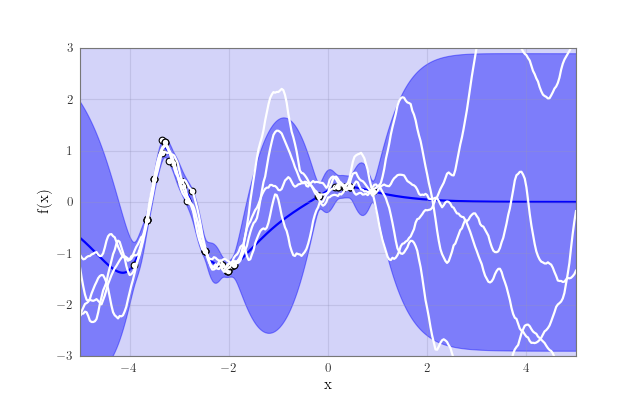

interactive(children=(Dropdown(description='Mean', options=('Linear', 'Zero'), value='Linear'), FloatSlider(va…

In [35]:
train_x = torch.tensor([])
train_y = torch.tensor([])
test_x = torch.linspace(-5, 5, 301)

clear_button = widgets.Button(description="Reset")
display(clear_button)
mean_chooser = widgets.Dropdown(description="Mean", options=["Linear", "Zero"])
kernel_chooser = widgets.Dropdown(description="Kernel", options=[
    "Matern",
    "Cosine",
    "Linear",
    "Linear + Matern",
    "Linear * Matern",
    "Spectral Mixture",
])
likelihood_chooser = widgets.Dropdown(description="Likelihood", options=["Gaussian"], disabled=True)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_xlim(test_x.min().item(), test_x.max().item())
ax.set_ylim(-2, 2)
ax.set_xlabel('x')
ax.set_ylabel('y')

# Mean parameters
a_slider = widgets.FloatSlider(description="$a$", value=0., min=-1., max=1., step=0.2)
b_slider = widgets.FloatSlider(description="$b$", value=0., min=-1., max=1., step=0.2)

# Kernel parameters
lengthscale_slider = widgets.FloatSlider(description="Lengthscale", value=1., min=0.1, max=2., step=0.1)
var_slider = widgets.FloatSlider(description="Var", value=1., min=0.1, max=2., step=0.1)
nu_slider = widgets.FloatSlider(description=r"$\nu$", value=2.5, min=0.5, max=3.5, step=1.,)

# Likelihood parameters
outputscale_slider = widgets.FloatSlider(description="Outputscale", value=1., min=0.1, max=3., step=0.1)
noise_slider = widgets.FloatSlider(description="Noise", value=0.01, min=0.01, max=0.1, step=0.01)


def clear_plot(b):
    global train_x, train_y
    train_x = torch.tensor([])
    train_y = torch.tensor([])
    update_plot()


def update_plot(
    mean="Linear",
    a=0, b=0,
    kernel="Matern", nu=2.5, lengthscale=1., var=1.,
    likelihood="Gaussian", outputscale=1., noise=0.01
):
    if likelihood != "Gaussian":
        raise ValueError(f"Likelihood must be Gaussian. Got {likelihood}")
    
    # Maybe disable sliders
    a_slider.disabled = (mean != "Linear")
    b_slider.disabled = (mean != "Linear")
    lengthscale_slider.disabled = ("Matern" not in kernel and "Cosine" not in kernel)
    var_slider.disabled = ("Linear" not in kernel)
    nu_slider.disabled = ("Matern" not in kernel)
    
    ax.clear()
    ax.fill_between(test_x.numpy(), -3, 3, color="blue", alpha=0.15)
    model = SimpleGP(
        train_x, train_y,
        mean=mean, a=a, b=b,
        kernel=kernel, nu=nu, lengthscale=lengthscale, var=var,
        outputscale=outputscale, noise=noise
    )
    
    # Compute predictive posterior
    plot_prior = train_x.numel() == 0  # We'll simply plot the GP prior when there's no data
    with torch.no_grad(), gpytorch.settings.prior_mode(plot_prior):
        model.eval()
        prediction = model(test_x)
        mean = prediction.mean
        lower, upper = prediction.confidence_region()

    # Plot predictive posterior
    ax.scatter(train_x, train_y, marker='o', edgecolors='k', color='white')
    mean_line, = ax.plot(test_x.numpy(), mean.numpy(), color='b', zorder=0)
    ax.fill_between(
        test_x.numpy(), lower.numpy(), upper.numpy(),
        color=mean_line.get_color(), alpha=0.4, zorder=-1,
    )
    ax.set(xlim=[-5., 5.], ylim=[-3., 3.], xlabel="x", ylabel="f(x)")
    
    # Plot samples
    torch.manual_seed(0)
    samples = prediction.rsample(torch.Size([4]))
    ax.plot(test_x, samples.T, color="white", zorder=1)


def onclick(event):
    global train_x, train_y
    new_x = torch.tensor([event.xdata], dtype=train_x.dtype)
    new_y = torch.tensor([event.ydata], dtype=train_y.dtype)
    train_x = torch.cat([train_x, new_x], 0) if train_x.numel() else new_x
    train_y = torch.cat([train_y, new_y], 0) if train_y.numel() else new_y
    update_plot(
        mean=mean_chooser.value,
        a=a_slider.value, b=b_slider.value,
        kernel=kernel_chooser.value,
        nu=nu_slider.value, lengthscale=lengthscale_slider.value, var=var_slider.value,
        likelihood=likelihood_chooser.value,
        outputscale=outputscale_slider.value, noise=noise_slider.value,
    )


clear_button.on_click(clear_plot)
interact(
    update_plot,
    mean=mean_chooser,
    a=a_slider, b=b_slider,
    kernel=kernel_chooser,
    nu=nu_slider, lengthscale=lengthscale_slider, var=var_slider,
    likelihood=likelihood_chooser,
    outputscale=outputscale_slider, noise=noise_slider,
)
update_plot()
cid = fig.canvas.mpl_connect('button_press_event', onclick)